In [2]:
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import requests
from dotenv import load_dotenv

In [3]:
load_dotenv()

BACKEND_USER = os.environ['BACKEND_USER']
BACKEND_PASSWORD = os.environ['BACKEND_PASSWORD']
BACKEND_URL = os.environ['BACKEND_URL']

experiment_type = 'reward-network-iii-6A-v2'
finished = True

In [4]:
url = f'{BACKEND_URL}/results'
headers = {'Accept': 'application/json'}
auth = (BACKEND_USER, BACKEND_PASSWORD)
current_datatime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# #---subjects----
subjects = requests.get(f'{url}/subjects', headers=headers, auth=auth)
subjects_df = pd.DataFrame(subjects.json())

#---sessions----
sessions = requests.get(f'{url}/sessions?experiment_type={experiment_type}&finished={finished}', headers=headers, auth=auth)
sessions_json = sessions.json()


def eval_move(edge, all_edges):
    max_reward = max([e['reward'] for e in all_edges])
    min_reward = min([e['reward'] for e in all_edges])
    
    myopic = edge['reward'] == max_reward
    has_large_loss = min_reward == -50
    large_loss_taken = edge['reward'] == -50
    
    optimal = large_loss_taken if has_large_loss else myopic
    
    return {
        'myopic': myopic,
        'optimal': optimal,
        'large_loss_taken': large_loss_taken,
    }
    


def get_moves(network: dict, moves_nodes: int):
    edges_by_source = {}
    for edge in network['edges']:
        edges_by_source.setdefault(edge['source_num'], []).append(edge)
        
    edges_by_source_target = {
        source_num: {
            edge['target_num']: edge
            for edge in edges
        }
        for source_num, edges in edges_by_source.items()
    }
        
        
    nodes_by_num = {
        node['node_num']: node
        for node in network['nodes']
    }

    moves = []
    for i, (source_num, target_num) in enumerate(zip(moves_nodes[:-1], moves_nodes[1:])):
        edges = edges_by_source_target[source_num]
        edge = edges[target_num]
        moves.append({
            "move_idx": i,
            "source_num": source_num,
            "target_num": target_num,
            "reward": edge['reward'],
            "level": nodes_by_num[target_num]['level'],
            **eval_move(edge, edges.values())
        })
    return moves


p_sessions = []
p_trails = []
p_moves = []
for session in sessions_json:
    for trail in session['trials']:
        if trail['solution'] is not None:
            moves = get_moves(trail['network'], trail['solution']['moves'])
            trails_info = {
                'session_id': session['_id'],
                'trail_id': trail['id'],
                'score': trail['solution']['score'],
            }
            moves = [{**m, **trails_info} for m in moves]
            p_moves.extend(moves)


moves_df = pd.DataFrame(p_moves)
trails_df = pd.DataFrame([{**t, 'session_id': s['_id']} for s in sessions_json for t in s['trials']])
sessions_df = pd.DataFrame([{k: v for k, v in s.items() if k != 'trails'} for s in sessions_json])

session_idx = {s: i for i, s in enumerate(moves_df['session_id'].unique())}
trail_idx = {s: i for i, s in enumerate(moves_df['trail_id'].unique())}

moves_df['session_idx'] = moves_df['session_id'].apply(lambda x: session_idx[x])
moves_df['trail_idx'] = moves_df['trail_id'].apply(lambda x: trail_idx[x])

In [5]:
moves_df

,move_idx,source_num,target_num,reward,level,myopic,optimal,large_loss_taken,session_id,trail_id,score,session_idx,trail_idx
0,0,1,3,0,0,False,False,False,655c7aba7cb69f5cd300575d,4,1300,0,0
1,1,3,5,0,0,False,False,False,655c7aba7cb69f5cd300575d,4,1300,0,0
2,2,5,1,200,0,True,True,False,655c7aba7cb69f5cd300575d,4,1300,0,0
3,3,1,5,100,0,True,False,False,655c7aba7cb69f5cd300575d,4,1300,0,0
4,4,5,1,200,0,True,True,False,655c7aba7cb69f5cd300575d,4,1300,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,5,8,7,100,0,True,False,False,655c7abb7cb69f5cd3005767,16,1100,9,9
962,6,7,3,100,0,True,False,False,655c7abb7cb69f5cd3005767,16,1100,9,9
963,7,3,4,0,0,False,False,False,655c7abb7cb69f5cd3005767,16,1100,9,9
964,8,4,7,200,0,True,False,False,655c7abb7cb69f5cd3005767,16,1100,9,9


<Axes: xlabel='trail_idx', ylabel='session_idx-move_idx'>

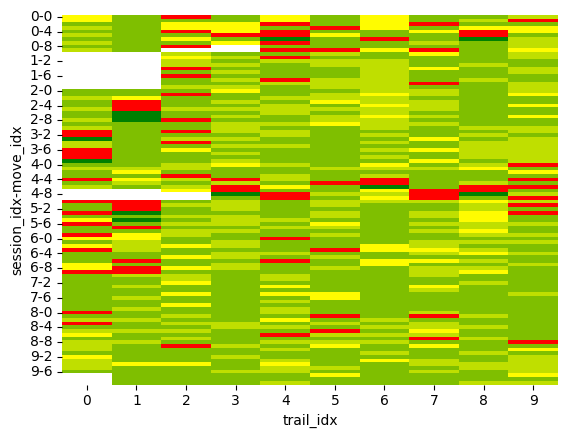

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns

moves_matrix = moves_df.pivot_table(index=['session_idx', 'move_idx'], columns=['trail_idx'], values='reward')

# Original nodes and colors
nodes = np.array([-50, 0, 400])
colors = ["red", "yellow", "green"]

# Normalize nodes to be in the range [0, 1]
norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))


sns.heatmap(moves_matrix, cmap=cmap, cbar=False)

<Axes: xlabel='trail_idx', ylabel='session_idx'>

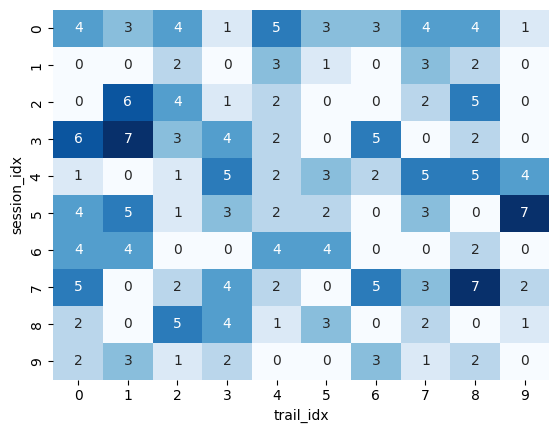

In [7]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trail_idx'], values='optimal', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)

<Axes: xlabel='trail_idx', ylabel='session_idx'>

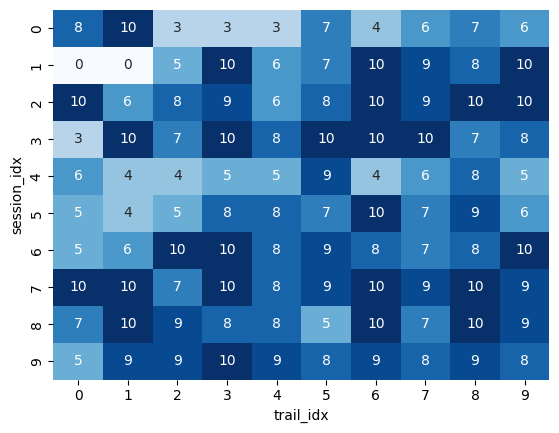

In [8]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trail_idx'], values='myopic', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)

<Axes: xlabel='trail_idx', ylabel='session_idx'>

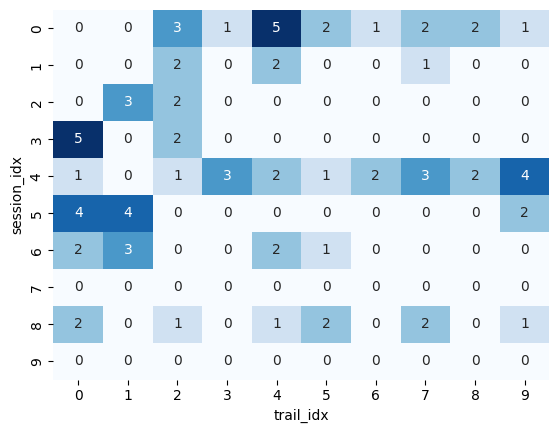

In [9]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trail_idx'], values='large_loss_taken', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)

In [10]:
# large_loss_taken, myopic, optimal
moves_behavior = moves_df.melt(id_vars=['session_idx', 'trail_idx'], value_vars=['large_loss_taken', 'myopic', 'optimal'], var_name='behavior', value_name='count')

<Axes: xlabel='trail_idx', ylabel='count'>

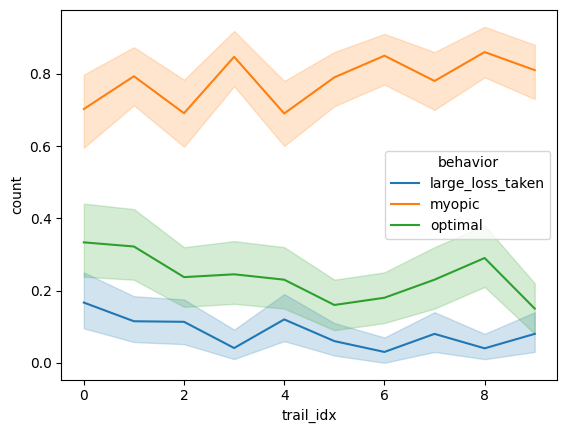

In [11]:
sns.lineplot(data=moves_behavior, x='trail_idx', y='count', hue='behavior')

<Axes: xlabel='trail_idx', ylabel='reward'>

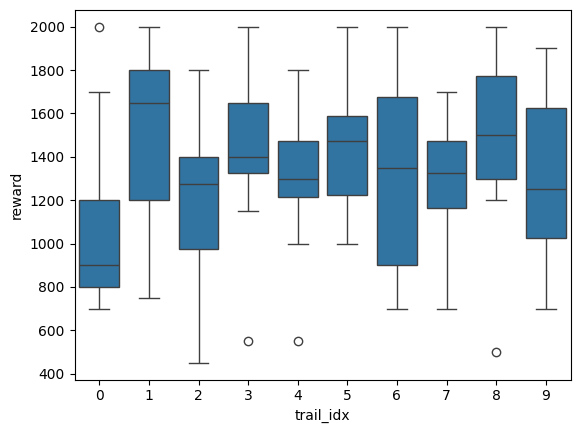

In [17]:
df_group = moves_df.groupby(['session_idx', 'trail_idx'])['reward'].sum().reset_index()

sns.boxplot(data=df_group, x='trail_idx', y='reward')